In [57]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [58]:
data_2021 =  pd.read_csv('/content/drive/MyDrive/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv')
data_2022 = pd.read_csv('/content/drive/MyDrive/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
data_2023 = pd.read_csv('/content/drive/MyDrive/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv')




In [59]:
# fix first occupany date entries in 2021 and 2022 data
data_2021.loc[0, "OCCUPANCY_DATE"] = "2021-01-01"
data_2021.loc[730, "OCCUPANCY_DATE"] = "2021-01-06"
data_2022.loc[0, "OCCUPANCY_DATE"] = "2022-01-01"

data = pd.concat([data_2021, data_2022, data_2023])




In [60]:
df = data[['OCCUPANCY_DATE', 'PROGRAM_ID', 'OCCUPANCY_RATE_BEDS']]
df = df.dropna()
df = df.replace("T00:00:00", "", regex=True)

In [62]:

df["OCCUPANCY_DATE"] = pd.to_datetime(df["OCCUPANCY_DATE"], format="%Y-%m-%d")
df["month"] = df["OCCUPANCY_DATE"].dt.month
df["year"] = df["OCCUPANCY_DATE"].dt.year
df["day"] = df["OCCUPANCY_DATE"].dt.day

In [63]:
def get_previous_day_bed_occupancy_rate():
    # Adds previous day's bed occupancy rate as a new column to the data
    df["PREV_DATE"] = df["OCCUPANCY_DATE"] - datetime.timedelta(days=1)
    prev_day_df = df[[
        "OCCUPANCY_DATE", "PROGRAM_ID", "OCCUPANCY_RATE_BEDS"
    ]].copy()

    # Renaming the columns for the merge operation
    prev_day_df.rename(columns={"OCCUPANCY_DATE": "PREV_DATE", "OCCUPANCY_RATE_BEDS": "PREV_OCCUPANCY_RATE_BEDS"}, inplace=True)

    # Merging the original dataframe with the previous day's data
    result = pd.merge(df, prev_day_df, how="left", on=["PREV_DATE", "PROGRAM_ID"])

    return result


In [ ]:
result = get_previous_day_bed_occupancy_rate()
result[result["PROGRAM_ID"] == 12251][["OCCUPANCY_DATE", "PREV_DATE", "OCCUPANCY_RATE_BEDS", "PREV_OCCUPANCY_RATE_BEDS"]].head(10)

,OCCUPANCY_DATE,PREV_DATE,OCCUPANCY_RATE_BEDS,PREV_OCCUPANCY_RATE_BEDS
0,2021-01-01,2020-12-31,75.0,NaN
88,2021-01-02,2021-01-01,75.0,75.0
176,2021-01-03,2021-01-02,75.0,75.0
264,2021-01-04,2021-01-03,75.0,75.0
352,2021-01-05,2021-01-04,75.0,75.0
440,2021-01-06,2021-01-05,75.0,75.0
528,2021-01-07,2021-01-06,75.0,75.0
616,2021-01-08,2021-01-07,75.0,75.0
704,2021-01-09,2021-01-08,75.0,75.0
792,2021-01-10,2021-01-09,75.0,75.0


In [ ]:
df = result.copy()
# drop days with missing previous day user counts
og_num_obs = len(df)
df = df.dropna()
print("Number of rows dropped: ", og_num_obs - len(df))
# check that 2021-01-01 day was dropped
assert(len(df[(df["day"] == 1) & (df["month"] == 1) & (df["year"] == 2021)]) == 0)

Number of rows dropped:  244


In [ ]:
# Split the DataFrame into training and testing sets
train_df = df[df['year'].isin([2021, 2022])]
train_df = train_df.drop(columns=["OCCUPANCY_DATE", "PREV_DATE"])
test_df = df[df['year'] == 2023]

In [ ]:
# Split into features and target
x_train = train_df.drop("OCCUPANCY_RATE_BEDS", axis=1)
y_train = train_df["OCCUPANCY_RATE_BEDS"]

x_test = test_df.drop("OCCUPANCY_RATE_BEDS", axis=1)
y_test = test_df["OCCUPANCY_RATE_BEDS"]

In [ ]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
# Test model
# Recursive Multi-step Forecast
total_y_pred = np.empty((0,))
total_y_test = test_df[test_df["OCCUPANCY_DATE"] == test_df["OCCUPANCY_DATE"].unique()[0]]["OCCUPANCY_RATE_BEDS"]
total_x_test = test_df[test_df["OCCUPANCY_DATE"] == test_df["OCCUPANCY_DATE"].unique()[0]].drop(columns=["OCCUPANCY_RATE_BEDS"])
program_id_tracker = pd.DataFrame()
date_tracker = pd.DataFrame()

for d in test_df["OCCUPANCY_DATE"].unique():
    # Predict one day at a time
    x_test = total_x_test[total_x_test["OCCUPANCY_DATE"] == d]
    program_id_tracker = pd.concat([program_id_tracker, x_test["PROGRAM_ID"]])
    date_tracker = pd.concat([date_tracker, x_test["OCCUPANCY_DATE"]])
    x_test = x_test.drop(columns=["OCCUPANCY_DATE", "PREV_DATE"])

    y_pred = rf.predict(x_test)

    total_y_pred = np.concatenate((total_y_pred, y_pred))

    next_day_rows = test_df[test_df["OCCUPANCY_DATE"] == d + datetime.timedelta(days=1)].drop(columns=["PREV_OCCUPANCY_RATE_BEDS"])
    if len(next_day_rows) > 0:
        temp = total_x_test[total_x_test["OCCUPANCY_DATE"] == d][["PROGRAM_ID"]].copy()
        temp["PREV_DATE"] = d
        temp["PREV_OCCUPANCY_RATE_BEDS"] = np.round(y_pred)

        result = pd.merge(next_day_rows, temp, how="left",
                      on=["PREV_DATE", "PROGRAM_ID"])
        result  = result.dropna()
        total_y_test = np.concatenate((total_y_test, result["OCCUPANCY_RATE_BEDS"]))
        result = result.drop(columns=["OCCUPANCY_RATE_BEDS"])

        total_x_test = pd.concat([total_x_test, result], ignore_index=True, axis=0)



In [ ]:
# Check model accuracy
mse = mean_squared_error(total_y_test, total_y_pred)
rmse = sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

mae = mean_absolute_error(total_y_test, total_y_pred)
print(f'Mean Absolute Error: {mae}')

Root Mean Squared Error: 7.039640145368943
Mean Absolute Error: 2.591327110214623


In [ ]:
# Preview predicted and actual values
comparison_df = pd.DataFrame({'Predicted': total_y_pred, 'Actual': total_y_test})
print(comparison_df)

       Predicted  Actual
0      100.00000  100.00
1      100.00000  100.00
2       99.95200  100.00
3       97.39504  100.00
4       96.52838   94.29
...          ...     ...
31476   99.81722  100.00
31477   99.83286  100.00
31478   98.07630  100.00
31479   99.75810  100.00
31480   99.32754   97.56

[31481 rows x 2 columns]


In [ ]:
program_id_tracker_np = program_id_tracker.values.astype(int)
date_tracker_np = date_tracker.values

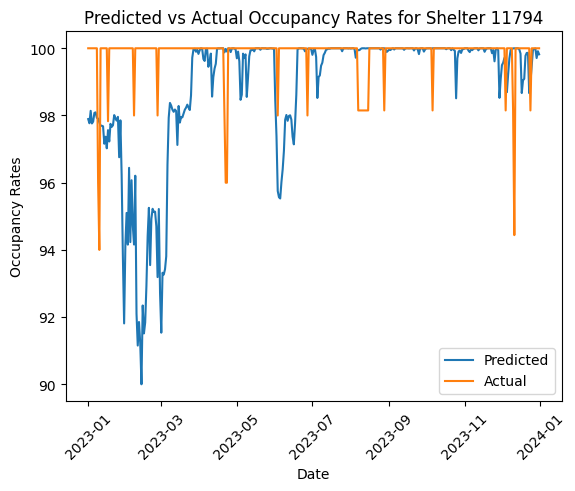

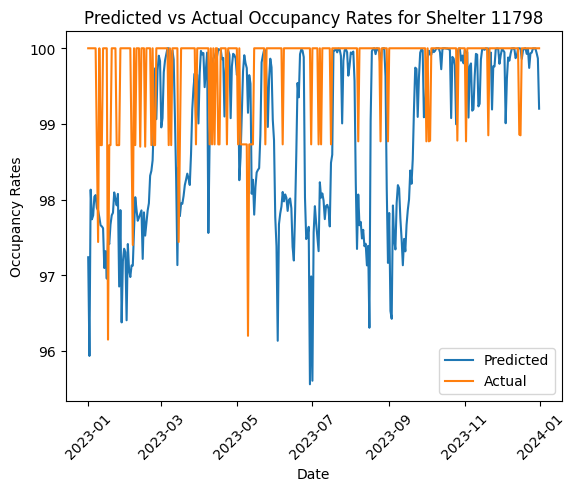

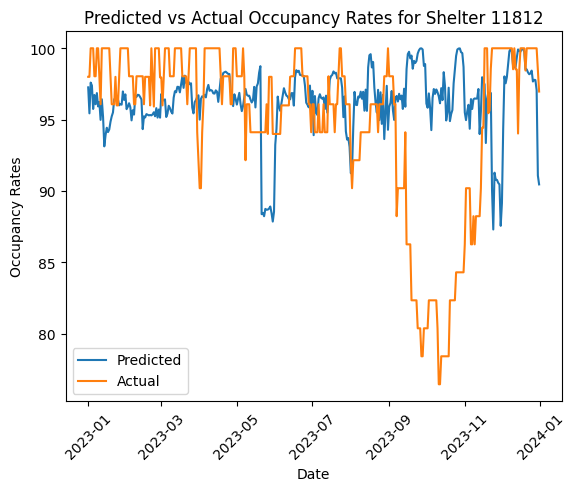

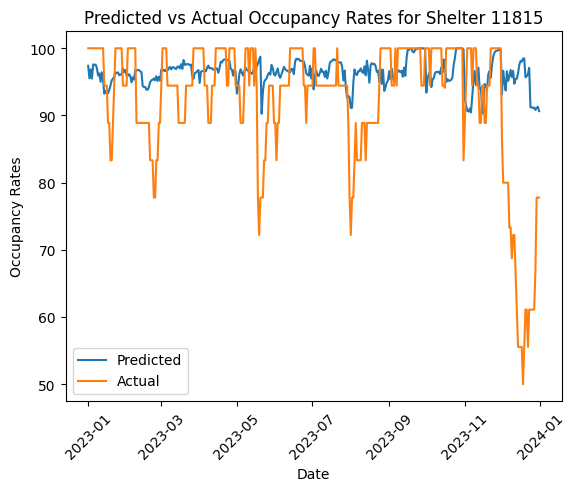

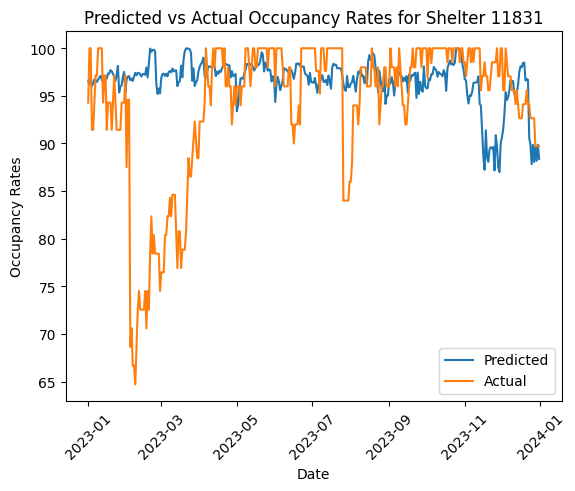

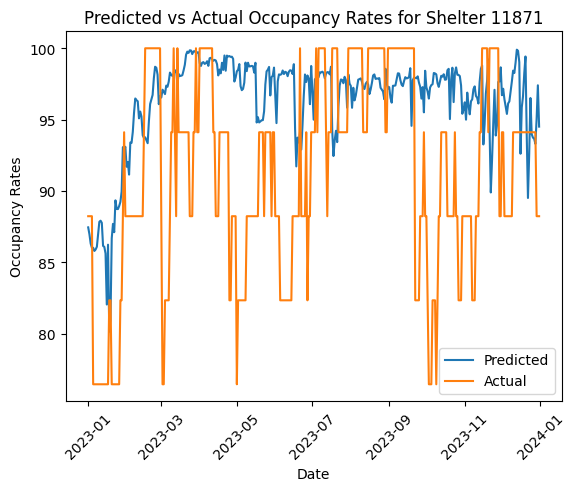

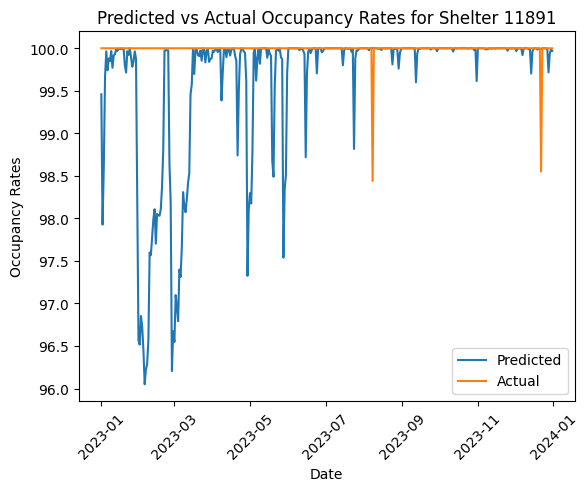

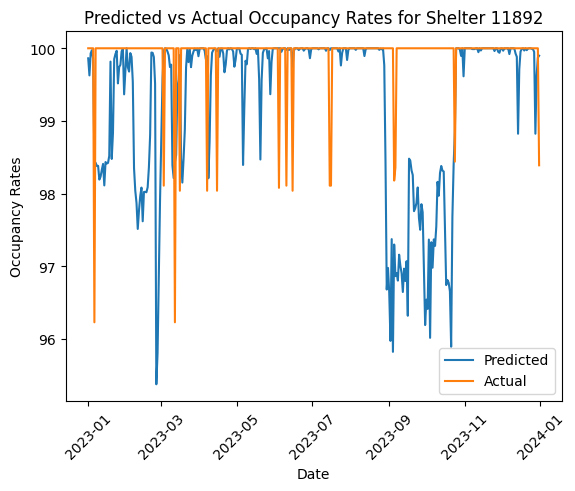

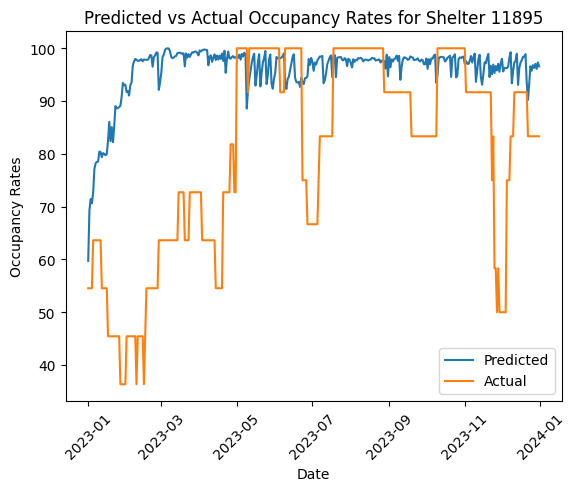

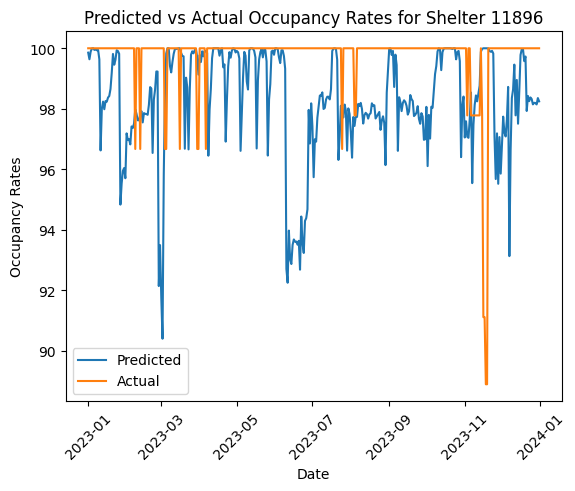

In [ ]:
# Plot predicted and actual occupancy rates for 10 shelters
count = 0
for id in np.unique(program_id_tracker_np):
  indices_id = np.where(program_id_tracker_np == id)[0]
  dates_id = date_tracker_np[indices_id]
  predicted_id = total_y_pred[indices_id]
  actual_id = total_y_test[indices_id]

  # Plot predicted and actual occupancy rates vs date for shelter 12251
  plt.plot(dates_id, predicted_id, label='Predicted')
  plt.plot(dates_id, actual_id, label='Actual')
  plt.xlabel('Date')
  plt.ylabel('Occupancy Rates')
  title = 'Predicted vs Actual Occupancy Rates for Shelter ' + str(id)
  plt.title(title)
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()
  count += 1
  if count==10:
    break